In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


Import Liabraries

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix,f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
#import graphviz
#from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score,confusion_matrix,mean_absolute_error,mean_squared_error,classification_report
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Problem Statment

KioMed, a huge pharmaceutical retailer, operates in in 10+ cities across India. The company has one distribution warehouse in each of the cities it operates in. Unfortunately, the warehouses are not able to consistently meet the demand of the stores in their respective cities. Kio, the parent company, being a data driven corporation wants to solve the stocking / inventory management problem using their in-house data science team

Reading and Understanding the data

In [3]:
pharma = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/train_data-1638436039700.csv", parse_dates={'date':['year','month','day']}, keep_date_col=False)
footfall = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/foot_fall-1638434879770.csv")
disfed = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/discount_features-1638436205304.csv")

Shape of Data

In [4]:
pharma.shape
footfall.shape
disfed.shape

(17277949, 4)

## Head And Tail Of Data

In [5]:
pharma.head()

,date,city,medicine,sales
0,2015-01-02,1,1,24.0
1,2015-01-02,1,2,144.0
2,2015-01-02,1,3,84.0
3,2015-01-02,1,4,24.0
4,2015-01-02,1,5,8.0


In [6]:
pharma.tail()

,date,city,medicine,sales
22624340,2018-06-30,10,3056,8.0
22624341,2018-06-30,10,3163,16.0
22624342,2018-06-30,10,3164,8.0
22624343,2018-06-30,10,3157,4.0
22624344,2018-06-30,10,3165,56.0


Head Of FootFall Data

In [7]:
footfall.head(10)

,city,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,2015-01-11,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-17,2015-01-18,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-24,2015-01-25,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-01-31,2015-02-01,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-07,2015-02-08,2015-02-09,...,2018-05-22,2018-05-23,2018-05-24,2018-05-25,2018-05-26,2018-05-27,2018-05-28,2018-05-29,2018-05-30,2018-05-31,2018-06-01,2018-06-02,2018-06-03,2018-06-04,2018-06-05,2018-06-06,2018-06-07,2018-06-08,2018-06-09,2018-06-10,2018-06-11,2018-06-12,2018-06-13,2018-06-14,2018-06-15,2018-06-16,2018-06-17,2018-06-18,2018-06-19,2018-06-20,2018-06-21,2018-06-22,2018-06-23,2018-06-24,2018-06-25,2018-06-26,2018-06-27,2018-06-28,2018-06-29,2018-06-30
0,Ahmedabad,9384.0,6808.0,8064.0,10248.0,11180.0,6876.0,6436.0,7104.0,5924.0,7072.0,9236.0,10648.0,6100.0,6284.0,7120.0,6272.0,7216.0,9876.0,10144.0,6228.0,6000.0,6424.0,5872.0,7220.0,10012.0,9652.0,6028.0,6064.0,6476.0,6292.0,7488.0,9972.0,10360.0,6840.0,6908.0,6672.0,6828.0,7652.0,7240.0,...,13532.0,9824.0,9324.0,10788.0,10476.0,13300.0,12096.0,12416.0,10632.0,12476.0,11916.0,10520.0,12296.0,13492.0,13092.0,10852.0,9716.0,11172.0,9624.0,11980.0,12760.0,11860.0,10324.0,9764.0,11120.0,10840.0,13140.0,16532.0,12292.0,10452.0,9624.0,10476.0,9584.0,11940.0,13040.0,12144.0,10164.0,9784.0,10472.0,10040.0
1,Bangalore,16644.0,14640.0,15660.0,19056.0,19740.0,14280.0,12740.0,13480.0,11928.0,13248.0,17112.0,19184.0,12580.0,13220.0,13624.0,12868.0,13208.0,17508.0,19508.0,13340.0,11892.0,12828.0,10952.0,12852.0,17452.0,18564.0,12600.0,11756.0,13032.0,13176.0,14880.0,20084.0,19740.0,14996.0,14036.0,14332.0,12984.0,14400.0,17308.0,...,17408.0,13024.0,11092.0,12960.0,12336.0,16996.0,15792.0,16872.0,13652.0,15536.0,15796.0,13244.0,14948.0,17976.0,18120.0,14480.0,12660.0,13652.0,12208.0,14536.0,16432.0,16000.0,12612.0,11940.0,14196.0,13336.0,15592.0,20908.0,17456.0,13780.0,12412.0,13392.0,11948.0,13860.0,16384.0,16192.0,12388.0,12124.0,13412.0,12172.0
2,Chennai,19544.0,13752.0,13736.0,19740.0,21604.0,12820.0,12244.0,11956.0,10508.0,11568.0,17052.0,18852.0,11120.0,11892.0,12136.0,11228.0,11628.0,17488.0,18784.0,12744.0,11144.0,11604.0,10492.0,12436.0,17456.0,17976.0,11188.0,10892.0,12020.0,12168.0,14084.0,19608.0,19176.0,13528.0,13924.0,12852.0,12756.0,13824.0,16956.0,...,16900.0,11372.0,9836.0,10196.0,10352.0,15640.0,14756.0,16208.0,11608.0,13504.0,12932.0,11180.0,12988.0,16964.0,17648.0,11384.0,10636.0,11260.0,10076.0,11552.0,16240.0,15636.0,10380.0,9688.0,11756.0,10924.0,12544.0,18432.0,15828.0,11656.0,10420.0,11044.0,10320.0,11988.0,15248.0,15188.0,10596.0,9716.0,10776.0,10336.0
3,Delhi,16832.0,13256.0,14520.0,17324.0,17672.0,13356.0,12408.0,13072.0,10788.0,12332.0,15708.0,17380.0,11748.0,12064.0,12732.0,11092.0,13052.0,15936.0,16676.0,12536.0,11036.0,11488.0,10368.0,12688.0,16672.0,16524.0,11488.0,11468.0,12088.0,12008.0,13952.0,17312.0,16792.0,13220.0,13012.0,12856.0,11620.0,14112.0,15768.0,...,16324.0,12212.0,10856.0,11548.0,11924.0,16948.0,16124.0,15776.0,12804.0,15280.0,13772.0,12056.0,14604.0,17540.0,17468.0,13100.0,12524.0,12808.0,11204.0,14672.0,16436.0,15676.0,12460.0,11508.0,12880.0,12464.0,15792.0,19120.0,15988.0,13020.0,12308.0,11772.0,11492.0,13284.0,16224.0,15688.0,11728.0,11164.0,12272.0,11692.0
4,Hyderabad,13588.0,11548.0,11600.0,16336.0,18364.0,10788.0,9280.0,9264.0,8848.0,9584.0,13420.0,15972.0,8892.0,9100.0,9372.0,8936.0,9364.0,13568.0,16176.0,9712.0,8520.0,8716.0,7888.0,9048.0,14512.0,15908.0,9232.0,8536.0,8828.0,9728.0,11644.0,16472.0,16772.0,11360.0,10936.0,10876.0,10312.0,11312.0,13820.0,...,14828.0,9756.0,8072.0,8520.0,8852.0,13888.0,13712.0,14768.0,9848.0,11388.0,11872.0,9636.0,10536.0,14952.0,16852.0,10204.0,9288.0,9280.0,9020.0,9444.0,13496.0,14436.0,8636.0,8444.0,9116.0,9252.0,10400.0,15676.0,15296.0,9536.0,8832.0,8756.0,8528.0,9464.0,13356.0,14384.0,

## Discount Feature Head

In [8]:
disfed.head()

,date,city,medicine,discounted
0,2016-04-01,1,1,0
1,2016-04-01,1,2,0
2,2016-04-01,1,3,0
3,2016-04-01,1,4,0
4,2016-04-01,1,5,0


In [9]:
disfed.tail()

,date,city,medicine,discounted
17277944,2018-07-31,10,3163,0
17277945,2018-07-31,10,3164,0
17277946,2018-07-31,10,3157,0
17277947,2018-07-31,10,3165,0
17277948,2018-07-31,10,3057,0


In [10]:
print(pharma.shape)
print(footfall.shape)
print(disfed.shape)

(22624345, 4)
(10, 1268)
(17277949, 4)


checking NA values

In [11]:
pharma.isna().sum()

date        0
city        0
medicine    0
sales       0
dtype: int64

In [12]:
print(pharma.date.nunique())
print(pharma.medicine.nunique())
print(pharma.city.nunique())
print(pharma.sales.nunique())

1269
3389
10
175574


## converting city into categorical

In [13]:
pharma['city'] = pharma.city.astype('category')

In [14]:
pharma.describe()

,medicine,sales
count,2.262434e+07,2.262434e+07
mean,1.169635e+03,5.166032e+01
std,8.016848e+02,1.100297e+02
min,1.000000e+00,-9.948000e+03
25%,5.110000e+02,1.200000e+01
50%,1.034000e+03,2.800000e+01
75%,1.718000e+03,5.600000e+01
max,3.389000e+03,8.299200e+04


## As expected found few negivite values in sales

In [15]:
negatives = pharma[pharma['sales']<0]
print(negatives.head())
negatives.shape

            date city  medicine  sales
17792 2015-01-03    6       117 -32.32
73647 2015-01-08    4        50  -8.00
83397 2015-01-09    2       785  -4.00
85164 2015-01-09    4       232  -8.00
86418 2015-01-09    5       253 -40.00


(1672, 4)

In [16]:
pharma.shape

(22624345, 4)

In [17]:
pharma.describe(include='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,date,city,medicine,sales
count,22624345,22624345.0,2.262434e+07,2.262434e+07
unique,1269,10.0,NaN,NaN
top,2018-02-28 00:00:00,4.0,NaN,NaN
freq,49607,2377044.0,NaN,NaN
first,2015-01-02 00:00:00,NaN,NaN,NaN
last,2018-06-30 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,1.169635e+03,5.166032e+01
std,NaN,NaN,8.016848e+02,1.100297e+02
min,NaN,NaN,1.000000e+00,-9.948000e+03
25%,NaN,NaN,5.110000e+02,1.200000e+01


## Exploring Train Data

In [18]:
#This is a function that provides the dtype, NA counts and levels within a variable
def understandData(pharma) :
    return(pd.DataFrame({"Datatype":pharma.dtypes,"No of NAs":pharma.isna().sum(),
                        "No of Levels":pharma.apply(lambda x: x.nunique(),axis=0),
                         "Levels":pharma.apply(lambda x: str(x.unique()),axis=0)}))

In [19]:
understandData(pharma)

,Datatype,No of NAs,No of Levels,Levels
date,datetime64[ns],0,1269,['2015-01-02T00:00:00.000000000' '2015-01-03T0...
city,category,0,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]\nCategories (1..."
medicine,int64,0,3389,[ 1 2 3 ... 3387 3388 3389]
sales,float64,0,175574,[ 24. 144. 84. ... 495.848 1194....


In [20]:
## grouping the data into single day to check sum of sales per day.
group_data = pharma.groupby('date').sales.sum()
group_data.head()

date
2015-01-02     867673.604
2015-01-03     586097.240
2015-01-04     615527.348
2015-01-05     865749.264
2015-01-06    1008641.084
Name: sales, dtype: float64

In [21]:
pharma.medicine.value_counts()

453     12699
245     12698
314     12698
177     12697
562     12694
        ...  
1516        1
1523        1
3369        1
3334        1
2679        1
Name: medicine, Length: 3389, dtype: int64

In [22]:
pharma.city.value_counts()

4     2377044
5     2357882
7     2340831
1     2307785
6     2273115
9     2248552
3     2221984
8     2207201
10    2175820
2     2114131
Name: city, dtype: int64

## visualization Of Data

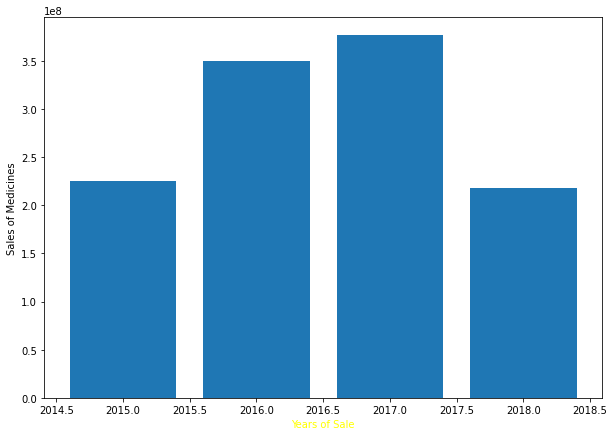

In [23]:
#Sales are higher for the years 2016 and 2017. 
yearlySales = pharma.groupby(pd.DatetimeIndex(pharma['date']).year).sales.sum()
years = range(2015,2019)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()
plt.bar(years, yearlySales)
plt.ylabel('Sales of Medicines')
plt.xlabel('Years of Sale')
ax.xaxis.label.set_color('yellow')

([<matplotlib.axis.XTick at 0x7f6ac46eeb10>,
 <a list of 10 Text major ticklabel objects>)

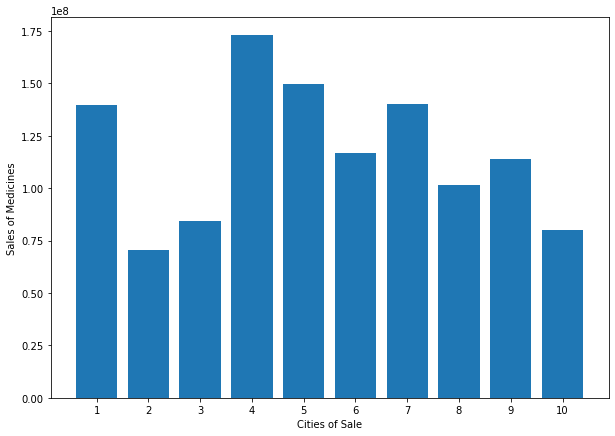

In [24]:
citySales = pharma.groupby('city').sales.sum()
cities = range(1,11)
plt.figure(figsize=(10,7))
plt.bar(cities, citySales)
plt.ylabel('Sales of Medicines')
plt.xlabel('Cities of Sale')
plt.xticks(cities)

In [25]:
pharma.groupby(['date', 'city']).medicine.nunique()

date        city
2015-01-02  1       1201
            2       1125
            3       1203
            4       1254
            5       1233
                    ... 
2018-06-30  6       2353
            7       2428
            8       2242
            9       2381
            10      2181
Name: medicine, Length: 12690, dtype: int64

In [26]:
pharma[(pharma['date']=='2018-02-28')& (pharma['city']==1)].medicine.value_counts()

2047    2
729     2
2796    2
2792    2
741     2
       ..
1148    1
970     1
3120    1
647     1
1129    1
Name: medicine, Length: 2690, dtype: int64

## Foot fall data

In [27]:
footfall1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/foot_fall-1638434879770.csv", header=[0], index_col=0)

In [28]:
footfall1.head(10)

,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,2015-01-11,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-17,2015-01-18,2015-01-19,2015-01-20,2015-01-21,2015-01-22,2015-01-23,2015-01-24,2015-01-25,2015-01-26,2015-01-27,2015-01-28,2015-01-29,2015-01-30,2015-01-31,2015-02-01,2015-02-02,2015-02-03,2015-02-04,2015-02-05,2015-02-06,2015-02-07,2015-02-08,2015-02-09,2015-02-10,...,2018-05-22,2018-05-23,2018-05-24,2018-05-25,2018-05-26,2018-05-27,2018-05-28,2018-05-29,2018-05-30,2018-05-31,2018-06-01,2018-06-02,2018-06-03,2018-06-04,2018-06-05,2018-06-06,2018-06-07,2018-06-08,2018-06-09,2018-06-10,2018-06-11,2018-06-12,2018-06-13,2018-06-14,2018-06-15,2018-06-16,2018-06-17,2018-06-18,2018-06-19,2018-06-20,2018-06-21,2018-06-22,2018-06-23,2018-06-24,2018-06-25,2018-06-26,2018-06-27,2018-06-28,2018-06-29,2018-06-30
city,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ahmedabad,9384.0,6808.0,8064.0,10248.0,11180.0,6876.0,6436.0,7104.0,5924.0,7072.0,9236.0,10648.0,6100.0,6284.0,7120.0,6272.0,7216.0,9876.0,10144.0,6228.0,6000.0,6424.0,5872.0,7220.0,10012.0,9652.0,6028.0,6064.0,6476.0,6292.0,7488.0,9972.0,10360.0,6840.0,6908.0,6672.0,6828.0,7652.0,7240.0,8480.0,...,13532.0,9824.0,9324.0,10788.0,10476.0,13300.0,12096.0,12416.0,10632.0,12476.0,11916.0,10520.0,12296.0,13492.0,13092.0,10852.0,9716.0,11172.0,9624.0,11980.0,12760.0,11860.0,10324.0,9764.0,11120.0,10840.0,13140.0,16532.0,12292.0,10452.0,9624.0,10476.0,9584.0,11940.0,13040.0,12144.0,10164.0,9784.0,10472.0,10040.0
Bangalore,16644.0,14640.0,15660.0,19056.0,19740.0,14280.0,12740.0,13480.0,11928.0,13248.0,17112.0,19184.0,12580.0,13220.0,13624.0,12868.0,13208.0,17508.0,19508.0,13340.0,11892.0,12828.0,10952.0,12852.0,17452.0,18564.0,12600.0,11756.0,13032.0,13176.0,14880.0,20084.0,19740.0,14996.0,14036.0,14332.0,12984.0,14400.0,17308.0,13588.0,...,17408.0,13024.0,11092.0,12960.0,12336.0,16996.0,15792.0,16872.0,13652.0,15536.0,15796.0,13244.0,14948.0,17976.0,18120.0,14480.0,12660.0,13652.0,12208.0,14536.0,16432.0,16000.0,12612.0,11940.0,14196.0,13336.0,15592.0,20908.0,17456.0,13780.0,12412.0,13392.0,11948.0,13860.0,16384.0,16192.0,12388.0,12124.0,13412.0,12172.0
Chennai,19544.0,13752.0,13736.0,19740.0,21604.0,12820.0,12244.0,11956.0,10508.0,11568.0,17052.0,18852.0,11120.0,11892.0,12136.0,11228.0,11628.0,17488.0,18784.0,12744.0,11144.0,11604.0,10492.0,12436.0,17456.0,17976.0,11188.0,10892.0,12020.0,12168.0,14084.0,19608.0,19176.0,13528.0,13924.0,12852.0,12756.0,13824.0,16956.0,13840.0,...,16900.0,11372.0,9836.0,10196.0,10352.0,15640.0,14756.0,16208.0,11608.0,13504.0,12932.0,11180.0,12988.0,16964.0,17648.0,11384.0,10636.0,11260.0,10076.0,11552.0,16240.0,15636.0,10380.0,9688.0,11756.0,10924.0,12544.0,18432.0,15828.0,11656.0,10420.0,11044.0,10320.0,11988.0,15248.0,15188.0,10596.0,9716.0,10776.0,10336.0
Delhi,16832.0,13256.0,14520.0,17324.0,17672.0,13356.0,12408.0,13072.0,10788.0,12332.0,15708.0,17380.0,11748.0,12064.0,12732.0,11092.0,13052.0,15936.0,16676.0,12536.0,11036.0,11488.0,10368.0,12688.0,16672.0,16524.0,11488.0,11468.0,12088.0,12008.0,13952.0,17312.0,16792.0,13220.0,13012.0,12856.0,11620.0,14112.0,15768.0,12524.0,...,16324.0,12212.0,10856.0,11548.0,11924.0,16948.0,16124.0,15776.0,12804.0,15280.0,13772.0,12056.0,14604.0,17540.0,17468.0,13100.0,12524.0,12808.0,11204.0,14672.0,16436.0,15676.0,12460.0,11508.0,12880.0,12464.0,15792.0,19120.0,15988.0,13020.0,12308.0,11772.0,11492.0,13284.0,16224.0,15688.0,11728.0,11164.0,12272.0,11692.0
Hyderabad,13588.0,11548.0,11600.0,16336.0,18364.0,10788.0,9280.0,9264.0,8848.0,9584.0,13420.0,15972.0,8892.0,9100.0,9372.0,8936.0,9364.0,13568.0,16176.0,9712.0,8520.0,8716.0,7888.0,9048.0,14512.0,15908.0,9232.0,8536.0,8828.0,9728.0,11644.0,16472.0,16772.0,11360.0,10936.0,10876.0,10312.0,11312.0,13820.0,12192.0,...,14828.0,9756.0,8072.0,8520.0,8852.0,13888.0,13712.0,14768.0,9848.0,11388.0,11872.0,9636.0,10536.0,14952.0,16852.0,10204.0,9288.0,9280.0,9020.0,9444.

## Transforming Data

In [29]:
footfallt = footfall1.T

In [30]:
footfallt = footfallt.rename(columns = {'city' : 'Date'})  # new method

In [31]:
footfallt.head()

city,Ahmedabad,Bangalore,Chennai,Delhi,Hyderabad,Jaipur,Kolkata,Lucknow,Mumbai,Other
2015-01-02,9384.0,16644.0,19544.0,16832.0,13588.0,13000.0,13948.0,12308.0,19284.0,8572.0
2015-01-03,6808.0,14640.0,13752.0,13256.0,11548.0,11616.0,12104.0,9228.0,14472.0,7180.0
2015-01-04,8064.0,15660.0,13736.0,14520.0,11600.0,11848.0,12752.0,10792.0,16676.0,6716.0
2015-01-05,10248.0,19056.0,19740.0,17324.0,16336.0,12240.0,14492.0,13836.0,19684.0,8616.0
2015-01-06,11180.0,19740.0,21604.0,17672.0,18364.0,10992.0,14360.0,13188.0,19700.0,9252.0


In [32]:
footfallt.tail()

city,Ahmedabad,Bangalore,Chennai,Delhi,Hyderabad,Jaipur,Kolkata,Lucknow,Mumbai,Other
2018-06-26,12144.0,16192.0,15188.0,15688.0,14384.0,10544.0,13348.0,10536.0,18640.0,8480.0
2018-06-27,10164.0,12388.0,10596.0,11728.0,8900.0,9632.0,11576.0,8136.0,14772.0,6480.0
2018-06-28,9784.0,12124.0,9716.0,11164.0,7792.0,9656.0,10752.0,7644.0,14208.0,6004.0
2018-06-29,10472.0,13412.0,10776.0,12272.0,8420.0,10316.0,11896.0,7860.0,16044.0,7144.0
2018-06-30,10040.0,12172.0,10336.0,11692.0,9240.0,9652.0,10528.0,7880.0,14628.0,6040.0


In [33]:
footfall.shape

(10, 1268)

In [34]:
footfallt.describe(include= 'all')

city,Ahmedabad,Bangalore,Chennai,Delhi,Hyderabad,Jaipur,Kolkata,Lucknow,Mumbai,Other
count,1267.000000,1267.000000,1267.000000,1267.00000,1267.000000,1266.000000,1266.000000,1267.000000,1267.000000,1266.000000
mean,10420.104183,15557.483820,14366.593528,14619.87056,12286.310971,11122.492891,12781.153239,10487.665351,17244.975533,7362.698262
std,2440.974478,2930.804283,3479.142221,2741.60429,3340.046714,1222.164990,1713.854951,2164.139714,2903.841046,1221.793863
min,5504.000000,3060.000000,9172.000000,8744.00000,7332.000000,5440.000000,8852.000000,7076.000000,9332.000000,5536.000000
25%,8918.000000,13370.000000,11850.000000,12530.00000,9786.000000,10452.000000,11548.000000,8938.000000,15186.000000,6496.000000
50%,10164.000000,14624.000000,12964.000000,13836.00000,10912.000000,11044.000000,12382.000000,9792.000000,16516.000000,6926.000000
75%,11830.000000,17772.000000,17100.000000,16752.00000,14892.000000,11583.000000,13799.000000,12020.000000,19040.000000,8259.000000
max,25064.000000,30908.000000,32004.000000,29220.00000,28176.000000,20808.000000,23244.000000,21824.000000,33436.000000,17024.000000


In [35]:
list(footfallt.columns)

['Ahmedabad',
 'Bangalore',
 'Chennai',
 'Delhi',
 'Hyderabad',
 'Jaipur',
 'Kolkata',
 'Lucknow',
 'Mumbai',
 'Other']

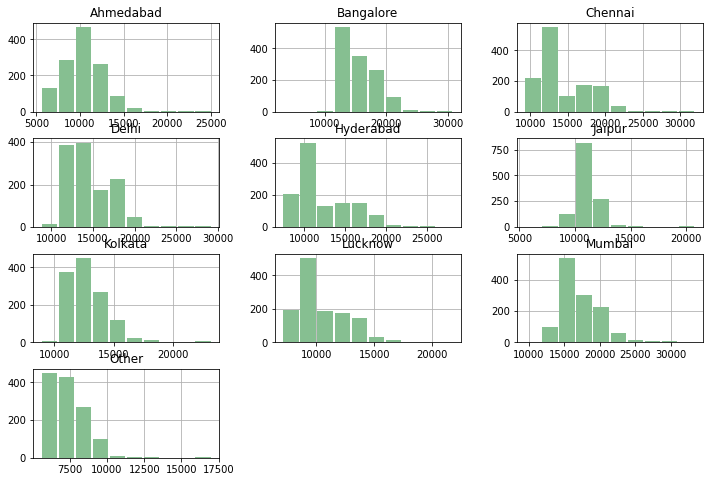

In [36]:
ff_hist = footfallt.hist(column=['Ahmedabad','Bangalore','Chennai','Delhi','Hyderabad','Jaipur','Kolkata','Lucknow','Mumbai','Other'], grid=True, figsize=(12,8), 
              color='#86bf91', zorder=2, rwidth=0.9)

## Fixing and Merging data

In [37]:
# converting date into datetime datatype and cities into categotical datatype
# I am looking to duplicated data points
pharma['city'] = pharma.city.astype('category')

In [38]:
pharma.dtypes

date        datetime64[ns]
city              category
medicine             int64
sales              float64
dtype: object

In [39]:
#Found there are 1827 duplicated data points in the given data.
dupli_data = pharma[pharma.duplicated(subset=['date', 'city', 'medicine','sales'], keep='first')]
dupli_data.shape

(1827, 4)

In [40]:
dupli_data.city.value_counts()

3     237
10    222
2     194
1     177
7     175
9     174
6     173
5     171
8     169
4     135
Name: city, dtype: int64

In [41]:
#dropping  the duplicates from Train data.
pharma.drop_duplicates(subset=['date', 'city', 'medicine','sales'], keep='first', inplace=True)

In [42]:
pharma.shape

(22622518, 4)

In [43]:
#Total sales on particular date in each city
pharma.groupby('date').sales.sum()

date
2015-01-02     867673.604
2015-01-03     586097.240
2015-01-04     615527.348
2015-01-05     865749.264
2015-01-06    1008641.084
                 ...     
2018-06-26    1537980.332
2018-06-27     955672.828
2018-06-28     796849.600
2018-06-29     964662.248
2018-06-30     779719.292
Name: sales, Length: 1269, dtype: float64

In [44]:
disfed.head()

,date,city,medicine,discounted
0,2016-04-01,1,1,0
1,2016-04-01,1,2,0
2,2016-04-01,1,3,0
3,2016-04-01,1,4,0
4,2016-04-01,1,5,0


In [45]:
disfed.tail()

,date,city,medicine,discounted
17277944,2018-07-31,10,3163,0
17277945,2018-07-31,10,3164,0
17277946,2018-07-31,10,3157,0
17277947,2018-07-31,10,3165,0
17277948,2018-07-31,10,3057,0


In [46]:
# converting city into categorical data type in discounted data set
disfed['city'] = disfed.city.astype('category')

In [47]:
disfed['date'] = disfed.date.astype('datetime64[ns]')

In [48]:
disfed.dtypes

date          datetime64[ns]
city                category
medicine               int64
discounted             int64
dtype: object

In [49]:
drop_ext= disfed[disfed['medicine']>3389].index

In [50]:
disfed1 = disfed.drop(drop_ext)

In [51]:
merge_data = pd.merge(pharma, disfed1, how = 'left', on= ['date', 'city', 'medicine'] )

In [52]:
merge_data.head()

,date,city,medicine,sales,discounted
0,2015-01-02,1,1,24.0,NaN
1,2015-01-02,1,2,144.0,NaN
2,2015-01-02,1,3,84.0,NaN
3,2015-01-02,1,4,24.0,NaN
4,2015-01-02,1,5,8.0,NaN


In [53]:
# removing decimal values from columns sales and discounted.
merge_data['sales'] = merge_data['sales'].astype(str).apply(lambda x: x.replace('.0',''))
merge_data['discounted'] = merge_data['discounted'].astype(str).apply(lambda x: x.replace('.0',''))